In [41]:
!pip uninstall scikit-survival --yes

Found existing installation: scikit-survival 0.1.dev1185+gdeb308f.d20241120
Uninstalling scikit-survival-0.1.dev1185+gdeb308f.d20241120:
  Successfully uninstalled scikit-survival-0.1.dev1185+gdeb308f.d20241120


In [42]:
!pip install ../ --upgrade --no-cache-dir

Processing /workspaces/scikit-survival
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.1.dev1185+gdeb308f.d20241120-cp312-cp312-linux_x86_64.whl size=3918132 sha256=cf1b44e66c32fbf5a7c470039317b046402c2c4c8591e2315bafe39bf62fbe89
  Stored in directory: /tmp/pip-ephem-wheel-cache-rj2pi104/wheels/73/1e/1f/f68ce9295a139a820627ce9f5f205a9cafb3b63a64feff14ec
Successfully built scikit-survival


In [43]:
import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sksurv.datasets import load_whas500, load_gbsg2, load_veterans_lung_cancer
from sksurv.ensemble import ComponentwiseGenGradientBoostingSurvivalAnalysis
from sksurv.custom import SurvivalCustom
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_whas500() #load_gbsg2() #load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [45]:
y

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       ( True, 2.970e+02), (False, 2.131e+03), ( True, 1.000e+00),
       (False, 2.122e+03), ( True, 1.496e+03), ( True, 9.200e+02),
       (False, 2.175e+03), (False, 2.173e+03), ( True, 1.671e+03),
       (False, 2.192e+03), ( True, 8.650e+02), (False, 2.166e+03),
       (False, 2.168e+03), ( True, 9.050e+02), ( True, 2.353e+03),
       (False, 2.146e+03), ( True, 6.100e+01), ( True, 2.358e+03),
       (False, 2.114e+03), (False, 2.132e+03), (False, 2.139e+03),
       (False, 2.048e+03), (False, 2.152e+03), ( True, 6.000e+00),
       (False, 2.156e+03), ( True, 1.180e+02), (False, 2.064e+03),
       ( True, 8.490e+02), ( True, 7.140e+02), (False, 2.057e+03),
       ( True, 2.000e+00), ( True, 7.000e+00), (False, 2.151e+03),
       ( True, 6.000e+00), ( True, 4.220e+02), ( True, 3.540e+02),
       (False, 2.065e+03), (False, 2.048e+03), ( True, 1.065e+03),
       ( True, 5.350e+02), (False, 2.118e+03), ( True, 9.700e+

In [46]:
estimator = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = RidgeCV(), loss="coxph")
estimator2 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = ExtraTreeRegressor(), loss="coxph")
estimator3 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = KernelRidge(), loss="coxph")
estimator5 = SurvivalCustom(regr = RidgeCV())
estimator6 = SurvivalCustom(regr = RandomForestRegressor())
estimator7 = GradientBoostingSurvivalAnalysis()

estimator.fit(X_train, y_train)
estimator2.fit(X_train, y_train)
estimator3.fit(X_train, y_train)
estimator5.fit(X_train, y_train)
estimator6.fit(X_train, y_train)
estimator7.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


GradientBoostingSurvivalAnalysis()

In [47]:
estimator.predict(X_test.iloc[0:9])

array([-0.23744205,  0.13872962, -0.14537712, -0.14036639,  0.20890057,
       -0.02275107, -0.11536319,  0.03961823, -0.09415743])

In [48]:
surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])
surv_funcs2 = estimator2.predict_survival_function(X_test.iloc[:1])
surv_funcs3 = estimator3.predict_survival_function(X_test.iloc[:1])
surv_funcs5 = estimator5.predict_survival_function(X_test.iloc[:1])
surv_funcs6 = estimator6.predict_survival_function(X_test.iloc[:1])
surv_funcs7 = estimator7.predict_survival_function(X_test.iloc[:1])

score_ridgecv = estimator.score(X_test, y_test)
score_extra = estimator2.score(X_test, y_test)
score_kernel = estimator3.score(X_test, y_test)
score_custom = estimator5.score(X_test, y_test)
score_random = estimator6.score(X_test, y_test)
score_gradient = estimator7.score(X_test, y_test)

print(estimator.score(X_test, y_test))
print(estimator2.score(X_test, y_test))
print(estimator3.score(X_test, y_test))
print(estimator5.score(X_test, y_test))
print(estimator6.score(X_test, y_test))
print(estimator7.score(X_test, y_test))

0.7197278911564626
0.6333333333333333
0.7251700680272108
0.7074829931972789
0.7945578231292517
0.7755102040816326


In [49]:
event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]

In [50]:
from sksurv.nonparametric import kaplan_meier_estimator

km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")

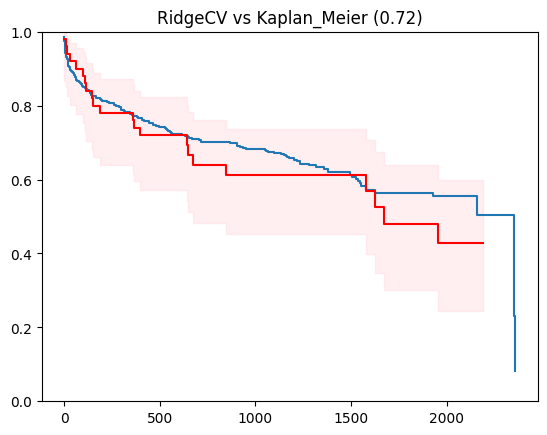

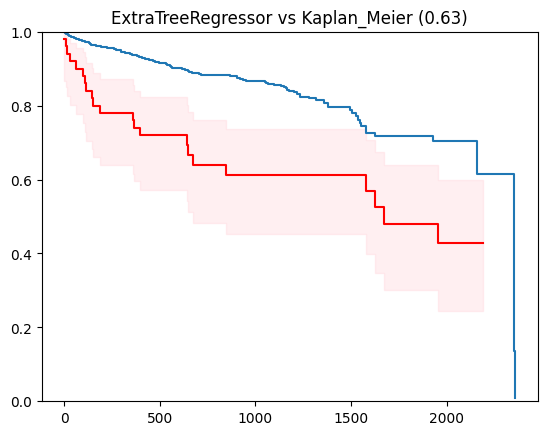

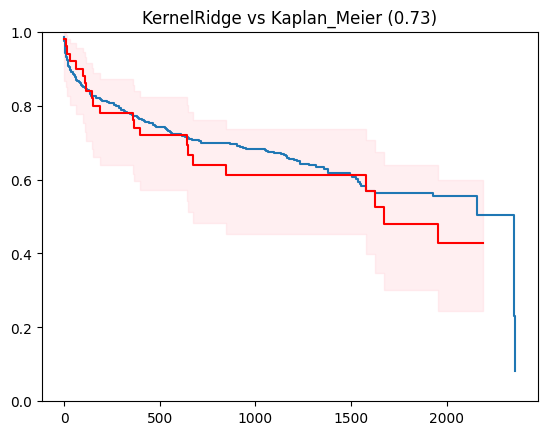

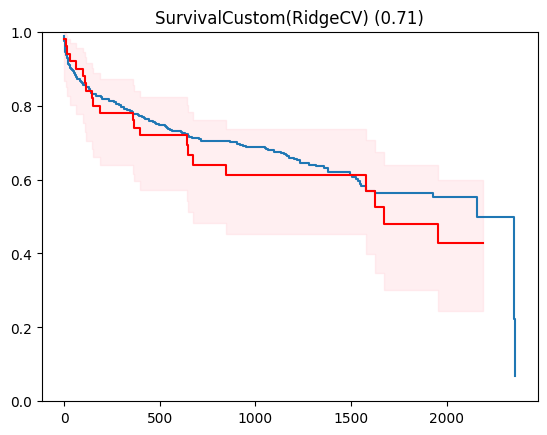

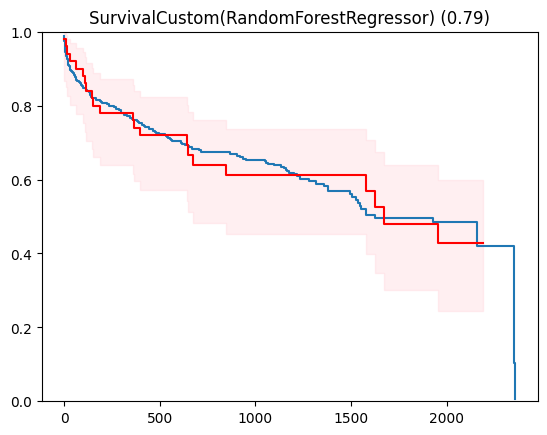

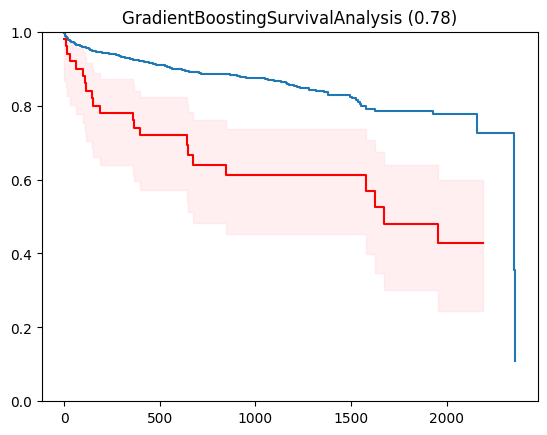

In [51]:
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"RidgeCV vs Kaplan_Meier ({np.round(score_ridgecv, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()


for fn in surv_funcs2:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"ExtraTreeRegressor vs Kaplan_Meier ({np.round(score_extra, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs3:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"KernelRidge vs Kaplan_Meier ({np.round(score_kernel, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()


for fn in surv_funcs5:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"SurvivalCustom(RidgeCV) ({np.round(score_custom, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs6:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"SurvivalCustom(RandomForestRegressor) ({np.round(score_random, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs7:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.title(f"GradientBoostingSurvivalAnalysis ({np.round(score_gradient, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()